<a href="https://colab.research.google.com/github/unoki/colabtest/blob/master/9_har_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第９章　人の活動の識別：データの基礎分析と前処理（プログラム）

第９章では、人の活動識別のためのデータセットを概観し、スケーリングなどの前処理を実施します。また、ディープラーニングの入力データとして次章ですぐに使えるように、3階のテンソルに変換してファイルに保存します。


### 学習項目

1. 準備
2. データの読み込み
3. データの概要の確認
4. ディープラーニング入力用にデータを変換
5. ファイルに保存

### 使用するファイル
- 9_har_eda.ipynb （このファイルです）
- data/uci_har/ 以下にある20のtxtファイル


### データセット

- UCI Machine Learning Repositoryで公開されているHuman Activity Recognition Using Smartphones Data Set から抜粋したもの。
- データは、公開時点で訓練用データとテスト用データに分かれている。
- ファイルは、スペース区切りのテキストファイル。


# 1. 準備
###  必要なライブラリの読み込み

- Pandas：ファイルの読み込みやデータの確認に使用します。
- NumPy：モデル入力用のデータを作成するために使用します。
- Seaborn：可視化のためのライブラリです。MatPlotlibのラッパーです。
- Sicket-learn：スケーリングに使用します。
- keras.utils.np_utils：カテゴリカルデータをOne-hot エンコーディングするために使用します。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from  sklearn.preprocessing import MinMaxScaler 
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### カレントディレクトリの移動

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202


### 参照用変数の準備
- アクティビティの番号と内容の対応が取りやすくなるように、辞書型の変数を定義しておきます。
- class_num は、アクティビティの数を代入しておきます。
- nrowsには、ファイルの読み込み行数を設定します。すべてのデータを読み込む場合はNoneを設定します。1回の実行に時間がかかるため、デバッグ中は少ないデータで実行ができるようにします。

In [0]:
class_num = 6
class_names = {1:'Walking',
               2:'Walk upstairs', 
               3:'Walk downstairs', 
               4:'Sitting', 
               5:'Standing', 
               6:'Laying'}

# ファイルの読み込み行数を指定します。最大数はtrain:7352, test:2947です。
# nrows = 1000
nrows = None

# 2.  データの読み込み
- データ読み込み用の関数を定義し、まとめて読み込む行数を指定できるようにします。
- 関数内でのファイルの読み込みには、Pandasのread_csv関数を使います。
- データファイルがスペース区切りのため、sepパラメータに```"\s+"```を指定します。
- 一つのファイルを、一つのDataFrameとします。
- 必要に応じて、shapeや、headなどでサイズや内容を確認してくみてください。

In [0]:
def read_csv(filename, nrows=nrows):
    return pd.read_csv(filename, header=None, sep="\s+", nrows=nrows)

# トレーニングデータ
y_train = read_csv('data/uci_har/y_train.txt')
total_acc_x_train = read_csv('data/uci_har/total_acc_x_train.txt')
total_acc_y_train = read_csv('data/uci_har/total_acc_y_train.txt')
total_acc_z_train = read_csv('data/uci_har/total_acc_z_train.txt')
body_acc_x_train = read_csv('data/uci_har/body_acc_x_train.txt')
body_acc_y_train = read_csv('data/uci_har/body_acc_y_train.txt')
body_acc_z_train = read_csv('data/uci_har/body_acc_z_train.txt')
body_gyro_x_train = read_csv('data/uci_har/body_gyro_x_train.txt')
body_gyro_y_train = read_csv('data/uci_har/body_gyro_y_train.txt')
body_gyro_z_train = read_csv('data/uci_har//body_gyro_z_train.txt')

# テストデータ
y_test = read_csv('data/uci_har/y_test.txt')
total_acc_x_test = read_csv('data/uci_har/total_acc_x_test.txt')
total_acc_y_test = read_csv('data/uci_har/total_acc_y_test.txt')
total_acc_z_test = read_csv('data/uci_har/total_acc_z_test.txt')
body_acc_x_test = read_csv('data/uci_har/body_acc_x_test.txt')
body_acc_y_test = read_csv('data/uci_har/body_acc_y_test.txt')
body_acc_z_test = read_csv('data/uci_har/body_acc_z_test.txt')
body_gyro_x_test = read_csv('data/uci_har/body_gyro_x_test.txt')
body_gyro_y_test = read_csv('data/uci_har/body_gyro_y_test.txt')
body_gyro_z_test = read_csv('data/uci_har/body_gyro_z_test.txt')

In [5]:
body_gyro_z_test.shape

(2947, 128)

# 3. データの概要の確認

### アクティビティによってデータ数に偏りがないか見てみる

- 可視化ライブラリとして、seabornを使います。
- seabornは、snsという名前でimportしてあります。
- seabornのcountplot関数で、ヒストグラムが表示してみましょう。
- orderパラメータで、出力する順番を指定できます。
- 辞書型のオブジェクトは、.keys()はキーリストを, values()は値のリストを取得できます。
- 以下では、map関数を使って、活動の番号を名前に変換しています。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


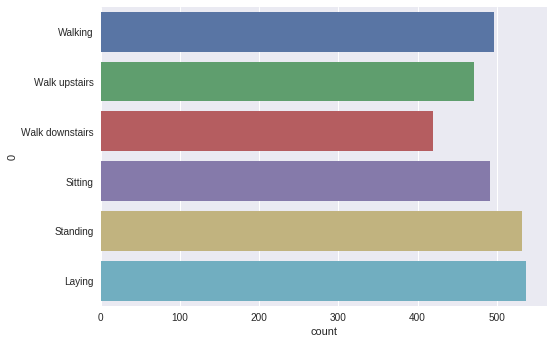

In [6]:
sns.countplot(y=y_test[0].map(class_names), order = class_names.values())

### 箱ひげ図で値の分布を見る
- アクティビティごとに箱ひげ図の位置が異なっていれば、識別しやすいといえます。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


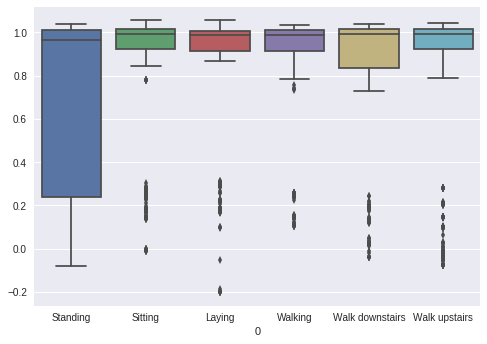

In [7]:
sns.boxplot(x=y_test[0].map(class_names), y=total_acc_x_train.mean(axis=1))

### センサー別にデータを表示してみる
- 多くのデータを一度にみたいので、データを一列にならべます。pandasのstack関数を使います。
- i番目からn個のデータを並べて表示してみましょう。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7620ca7f98>,
      dtype=object)

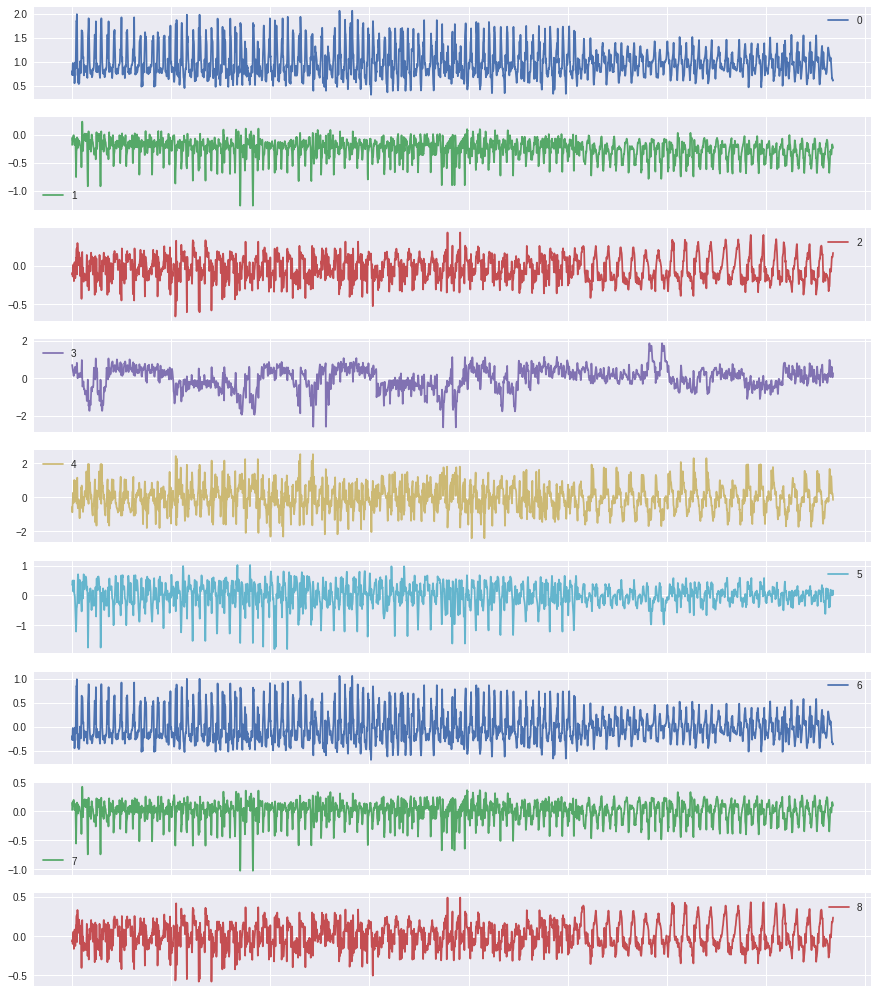

In [8]:
i=130
n=160
pd.concat([total_acc_x_train[i:n].stack(), total_acc_y_train[i:n].stack(), total_acc_z_train[i:n].stack(),
          body_gyro_x_train[i:n].stack(), body_gyro_y_train[i:n].stack(), body_gyro_z_train[i:n].stack(),
          body_acc_x_train[i:n].stack(), body_acc_y_train[i:n].stack(), body_acc_z_train[i:n].stack()],
        axis=1).plot(subplots=True, figsize=(15,20))

# 4. ディープラーニング入力用にデータを変換

- Kerasのモデルに入力できるよう、データのShapeを (サンプル数, シーケンス長, 次元数) の３階のテンソルに変換します。

In [0]:
def to_3darray(df_list):
    array_list = []
    for df in df_list:
        nd_array = np.array(df)
        array_list.append(
            np.reshape(nd_array, 
                       (nd_array.shape[0], nd_array.shape[1], 1)))
    return np.concatenate(array_list, axis=2)

# トレーニングデータの特徴量
train_df_list = [total_acc_x_train, total_acc_y_train, total_acc_z_train,
                 body_acc_x_train, body_acc_y_train, body_acc_z_train,
                 body_gyro_x_train, body_gyro_y_train, body_gyro_z_train]
X_train = to_3darray(train_df_list)

# テストデータの特徴量
test_df_list = [total_acc_x_test, total_acc_y_test, total_acc_z_test,
                body_acc_x_test, body_acc_y_test, body_acc_z_test,
                body_gyro_x_test, body_gyro_y_test, body_gyro_z_test]
X_test = to_3darray(test_df_list)

- ScikitLearnのMinMaxScalerを使って、データを0から1の範囲にスケーリングしておきます。

In [0]:
sc = MinMaxScaler()
X_train_scf = sc.fit_transform(X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
X_train = X_train_scf.reshape(X_train.shape)
X_test_scf = sc.transform(X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2]))
X_test = X_test_scf.reshape(X_test.shape)

- 正解ラベルをone-hotエンコーディングします。
- 取り扱いを容易にするため、1から6の範囲のIDを、0から5の範囲に変換します。

In [0]:
Y_train = to_categorical(y_train - 1)
Y_test = to_categorical(y_test - 1)

- データのShapeを確認しておきましょう。

In [12]:
X_train.shape, y_train.shape, Y_train.shape, X_test.shape, y_test.shape, Y_test.shape

((7352, 128, 9), (7352, 1), (7352, 6), (2947, 128, 9), (2947, 1), (2947, 6))

# 5. ファイルに保存
- 作成したNumPy ndarrayをファイルに保存します。NumPyのsave関数を使います。拡張子は.npyになります。
- 読み込みたいときは、load関数を使います。

In [0]:
np.save('data/X_train', X_train)
np.save('data/Y_train', Y_train)
np.save('data/X_test',  X_test)
np.save('data/Y_test', Y_test)